In [1]:
import pandas as pd
import numpy as np
import json
import trimesh
import matplotlib.pyplot as plt
import pyglet
from pyglet.gl import *
import pyvista as pv
from mpl_toolkits.mplot3d import Axes3D
import ast
import mne
from sklearn.cluster import KMeans
from itertools import cycle

In [2]:
in_df = pd.read_parquet(
    "/Users/siyuanzhao/Documents/DATADIR/patients/ep129/sample1/eegdb.parquet",
    engine="pyarrow",
)

electrodes = (
    26,
    28,
    36,
    20,
    32,
    21,
    22,
    40,
    41,
    54,
    19,
    31,
    39,
    47,
    48,
    52,
    56,
    27,
    29,
    34,
    35,
    43,
    49,
    50,
    53,
    18,
    33,
    44,
    30,
    38,
    51,
    37,
    108,
    109,
    107,
    102,
    112,
    55,
    45,
    23,
    103,
    73,
    74,
    76,
    75,
    84,
    89,
)
eeg_data_df_filtered = in_df[
    (in_df["electrode"].isin(electrodes)) & (in_df["ms"] >= 0) & (in_df["ms"] <= 500)
]
output = {}
for electode in electrodes:
    output[electode] = eeg_data_df_filtered.loc[
        eeg_data_df_filtered.electrode == electode
    ].value.values.tolist()

with open("ep129_sample1_0_500_egg.json", "w") as f:
    json.dump(output, f)

KeyboardInterrupt: 

In [ ]:
in_df = pd.read_parquet(
    "/Users/siyuanzhao/Documents/DATADIR/patients/ep187/sample1/eegdb.parquet",
    engine="pyarrow",
)

electrodes = (95,60,61,59,72,70,79,71,78,87,58,63,62)
eeg_data_df_filtered = in_df[
    (in_df["electrode"].isin(electrodes))
    & (in_df["ms"] >= 14000)
    & (in_df["ms"] <= 14500)
]
output = {}
for electode in electrodes:
    output[electode] = eeg_data_df_filtered.loc[
        eeg_data_df_filtered.electrode == electode
    ].value.values.tolist()

with open('ep187_sample1_14000_14500_egg.json', 'w') as f:
    json.dump(output, f)

In [ ]:
propogation_df = pd.read_json(
    "/Users/siyuanzhao/Documents/DATADIR/patients/ep129/sample1/ep129_sorted_data.json"
)
propogation_test_df = propogation_df[propogation_df["eventIndex"] == 1]
# save ep129, sample1, event 1 electrode propagation json to local
propogation_test_df.to_json("ep129_sample1_electrode_event1.json", index=False)

In [ ]:
propogation_df = pd.read_json(
    "/Users/siyuanzhao/Documents/DATADIR/patients/ep187/sample1/ep187_sorted_data.json"
)
propogation_test_df = propogation_df[propogation_df["eventIndex"] == 45]
# save ep129, sample1, event 1 electrode propagation json to local
propogation_test_df.to_json("ep187_sample1_electrode_event45.json", index=False)

In [ ]:

# Load the brain model
mesh = trimesh.load('/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/models/ep187/ep187_brain_left.obj')

radius = 1.0 

# Calculate the curvature at each vertex
curvatures = trimesh.curvature.discrete_gaussian_curvature_measure(mesh, mesh.vertices, radius)

# Threshold for identifying 'key points'
threshold = np.percentile(curvatures, 80)  # top 5% curvature points

# Filter vertices with curvature above the threshold
key_points = mesh.vertices[curvatures > threshold]
key_points_list = [list(point) for point in key_points]

with open('key_points.json', 'w') as file:
    json.dump(key_points_list, file)


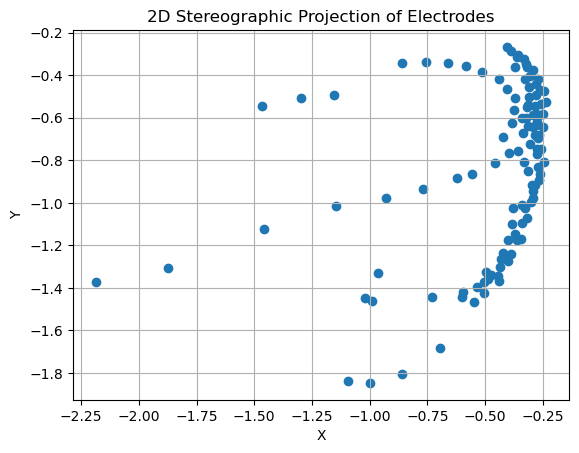

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

electrode_df = pd.read_csv(
    "/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois.csv"
)
# electrode_filtered_df = electrode_df[electrode_df["label"] == 201]
electrode_df["position"] = electrode_df["position"].apply(ast.literal_eval)

def stereographic_projection(x, y, z):
    X = x / (1 - z)
    Y = y / (1 - z)
    return X, Y

points_3d = np.array(electrode_df["position"])

points_2d = np.array([stereographic_projection(x, y, z) for x, y, z in points_3d])

# Plot
plt.scatter(points_2d[:, 0], points_2d[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stereographic Projection of Electrodes')
plt.grid(True)
plt.show()

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


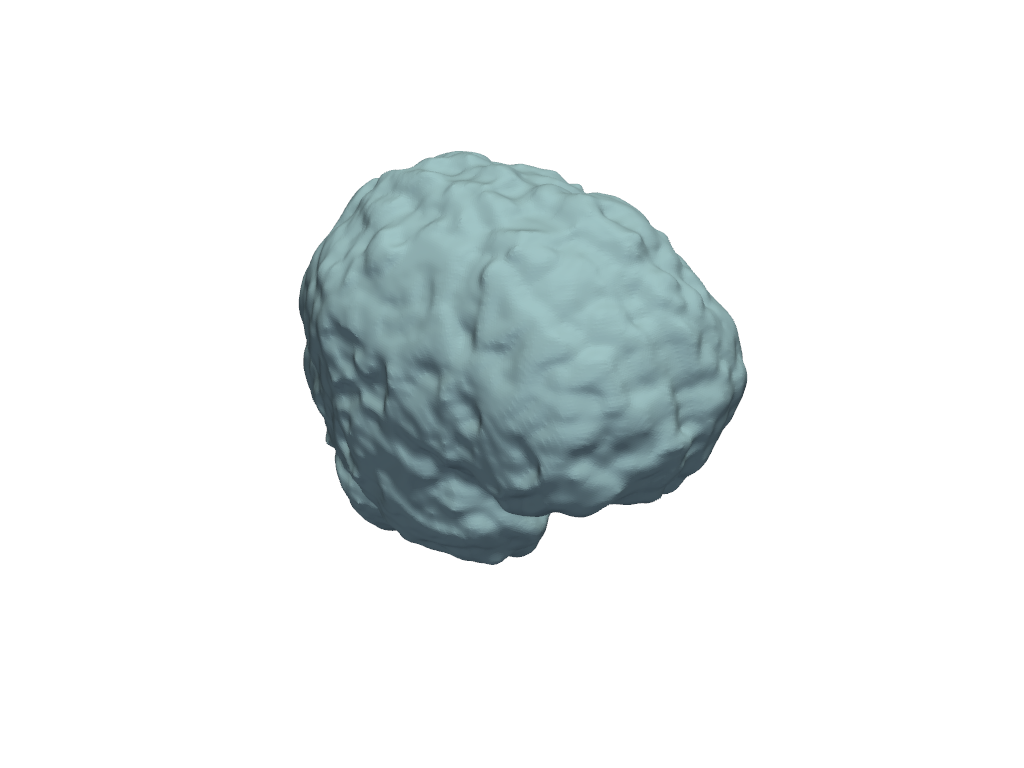

In [ ]:
mesh = trimesh.load('/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/models/ep187/ep187_brain.obj')
plotter = pv.Plotter()
plotter.add_mesh(mesh)
plotter.show()

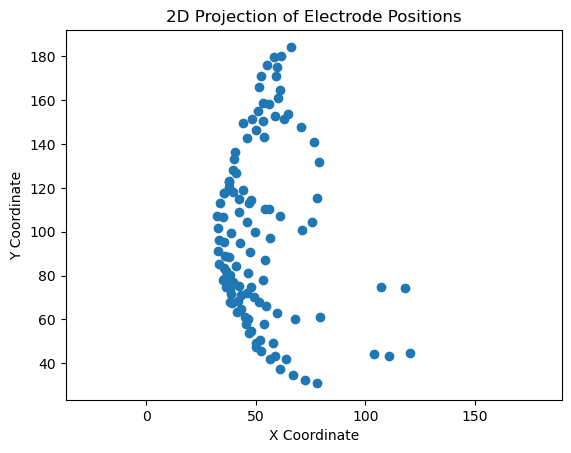

In [79]:
# Orthographic Projection

electrode_df = pd.read_csv(
    "/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois.csv"
)

# electrode_filtered_df = electrode_df[electrode_df["label"] == 201]
electrode_df["position"] = electrode_df["position"].apply(ast.literal_eval)

electrodes_3d = np.array(list(electrode_df["position"]))
electrodes_2d = electrodes_3d[:, :2]

# Plotting
plt.scatter(electrodes_2d[:, 0], electrodes_2d[:, 1])
plt.title('2D Projection of Electrode Positions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')  # Equal aspect ratio for X and Y
plt.show()

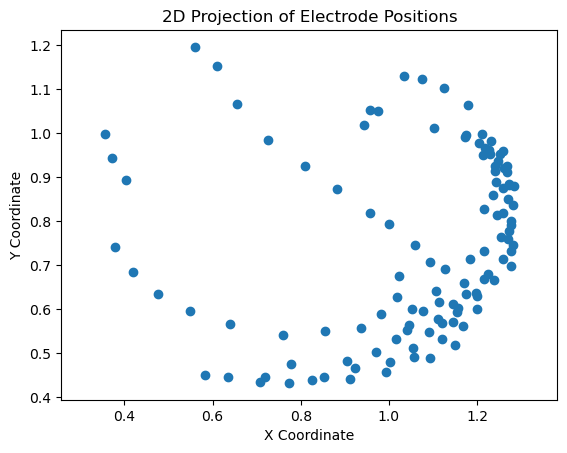

In [80]:
# Spherical Projection

electrode_df = pd.read_csv(
    "/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois.csv"
)
# electrode_filtered_df = electrode_df[electrode_df["label"] == 201]
electrode_df["position"] = electrode_df["position"].apply(ast.literal_eval)
 
electrodes_3d =np.array(list(electrode_df["position"]))
rho = np.sqrt(np.sum(electrodes_3d**2, axis=1))
phi = np.arctan2(electrodes_3d[:,1], electrodes_3d[:,0])  # Longitude
theta = np.arccos(electrodes_3d[:,2] / rho)  # Latitude

# Use phi and theta as 2D coordinates
electrodes_2d = np.column_stack((phi, theta))

# Plotting
plt.scatter(electrodes_2d[:, 0], electrodes_2d[:, 1])
plt.title('2D Projection of Electrode Positions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')  # Equal aspect ratio for X and Y
plt.show()

/Users/siyuanzhao/anaconda3/envs/VDS/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


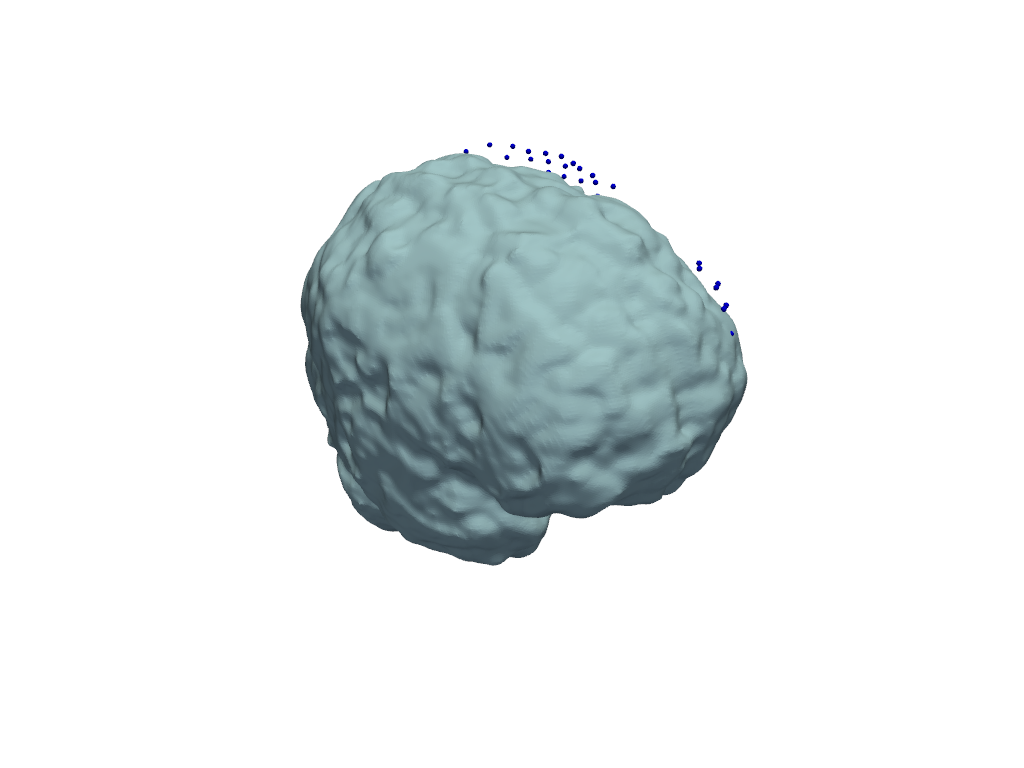

In [9]:
electrode_df = pd.read_csv(
    "/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois.csv"
)
mesh = trimesh.load('/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/models/ep187/ep187_brain.obj')
value_to_add = np.array([-98.18610191345215, -108.80819797515869, -118.60360145568848]) 
electrode_df["position"] = electrode_df["position"].apply(ast.literal_eval)
electrodes_3d = np.array(list(electrode_df["position"]))
adjusted_positions = electrodes_3d + value_to_add
plotter = pv.Plotter()

# Add electrodes to the scene
for pos in adjusted_positions:
    sphere = pv.Sphere(radius=1, center=pos)
    plotter.add_mesh(sphere, color='blue')  # Change color as needed

plotter.add_mesh(mesh)

# Display the plotter
plotter.show()

Creating RawArray with float64 data, n_channels=43, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_96758/1431847118.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electrode_filtered_df["position"] = electrode_filtered_df["position"].apply(ast.literal_eval)
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_96758/1431847118.py:22: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_96758/1431847118.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne.viz.plot_montage(montage)


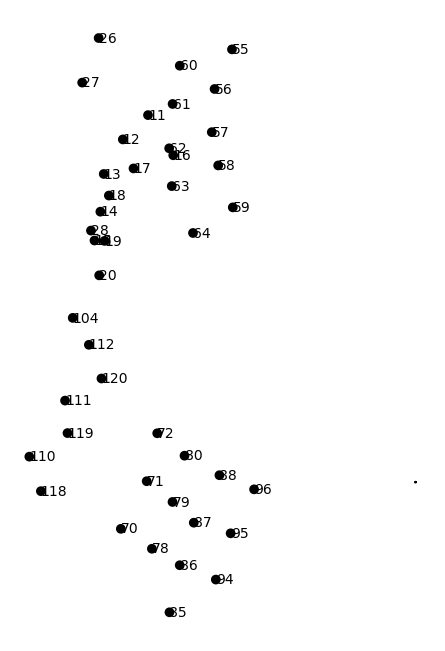

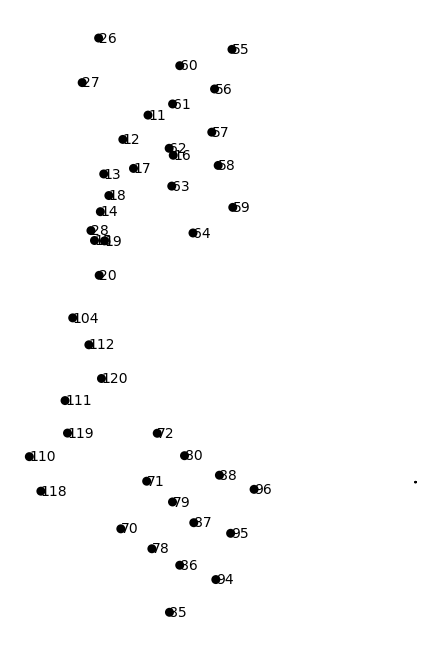

In [32]:
electrode_df = pd.read_csv(
    "/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois.csv"
)

value_to_add = np.array([-98.18610191345215, -108.80819797515869, -118.60360145568848]) 
# electrode_filtered_df = electrode_df
electrode_filtered_df = electrode_df[electrode_df["label"] == 101]
electrode_filtered_df["position"] = electrode_filtered_df["position"].apply(ast.literal_eval)
electrodes_3d = np.array(list(electrode_filtered_df["position"]))
adjusted_positions = electrodes_3d + value_to_add

electrode_positions_3d = {str(int(num)): tuple(pos) for num, pos in zip(electrode_filtered_df["electrode_number"], adjusted_positions)}

# Create a montage from these positions
montage = mne.channels.make_dig_montage(ch_pos=electrode_positions_3d)

# Create a dummy Info object with the same number of channels as electrodes
info = mne.create_info(ch_names=list(electrode_positions_3d.keys()), sfreq=1000, ch_types='eeg')

# Create a dummy Raw object and set the montage
raw = mne.io.RawArray(np.zeros((len(electrode_positions_3d), 1)), info)
raw.set_montage(montage)

# Visualize the 2D projection
mne.viz.plot_montage(montage)


Creating RawArray with float64 data, n_channels=43, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs


Ready.


/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_96758/1136181579.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electrode_filtered_df["position"] = electrode_filtered_df["position"].apply(ast.literal_eval)
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_96758/1136181579.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_96758/1136181579.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne.viz.plot_montage(montage)


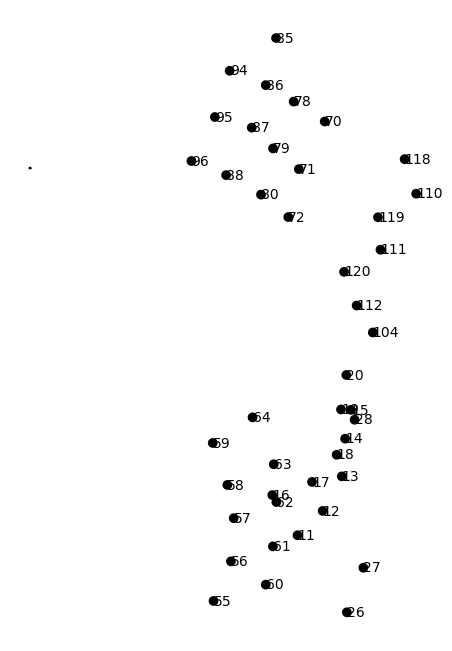

/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_96758/1136181579.py:41: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info.set_montage(montage)


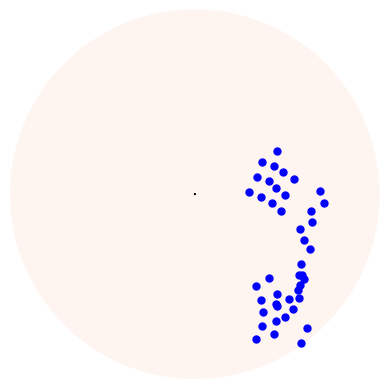

[[ 41.17202667 -56.50766335]
 [ 45.04641203 -52.76577838]
 [ 47.98647602 -47.44800501]
 [ 48.50696937 -41.64271116]
 [ 49.40916296 -37.20672512]
 [ 37.28788388 -50.32847466]
 [ 43.40706395 -48.30218077]
 [ 47.19812439 -44.1259001 ]
 [ 47.87013637 -37.1488417 ]
 [ 48.68645251 -31.84396367]
 [ 48.77121849 -68.36896654]
 [ 51.30531312 -61.50988572]
 [ 49.9545405  -38.73262136]
 [ 28.24836615 -66.62515794]
 [ 30.92791482 -60.52976031]
 [ 31.35518193 -53.88252532]
 [ 30.37150178 -48.76311549]
 [ 28.12289528 -42.30407352]
 [ 36.28496111 -64.11252552]
 [ 37.38871491 -58.22376064]
 [ 37.91668567 -51.39838196]
 [ 37.5159415  -45.57998864]
 [ 34.24902498 -38.36504322]
 [ 45.35581842   7.17470937]
 [ 41.37691276  -0.15608468]
 [ 39.75324684  -7.53597481]
 [ 40.57698596  10.24123505]
 [ 37.40231552   3.03662976]
 [ 35.55399062  -4.08382999]
 [ 37.87007179  20.0208752 ]
 [ 36.29078677  12.77662885]
 [ 34.12784506   6.23098373]
 [ 30.18064021  -1.07813625]
 [ 30.73382981  14.9845908 ]
 [ 28.45541941

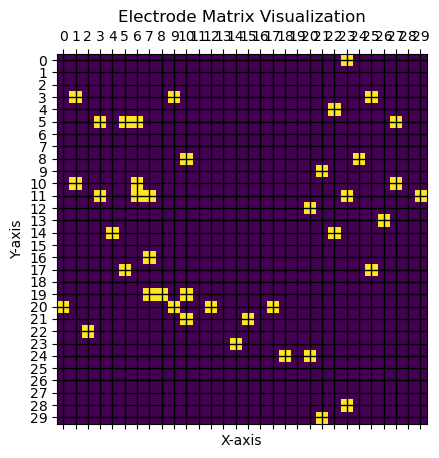

In [77]:
# Read the CSV file
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois.csv")
# electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_new.csv")

# Define the value to add
value_to_add = np.array([-98.18610191345215, -108.80819797515869, -118.60360145568848]) 

# Filter the dataframe
electrode_filtered_df = electrode_df[electrode_df["label"] == 101]

# Convert the position strings to tuples
electrode_filtered_df["position"] = electrode_filtered_df["position"].apply(ast.literal_eval)

# Extract 3D positions and adjust them
electrodes_3d = np.array(list(electrode_filtered_df["position"]))
# adjusted_positions = electrodes_3d
adjusted_positions = electrodes_3d + value_to_add

# Apply a 180-degree rotation around the z-axis
rotated_positions = np.copy(adjusted_positions)
rotated_positions[:, 0] *= -1  # Invert x-coordinate
rotated_positions[:, 1] *= -1  # Invert y-coordinate
# No change to z-coordinate for rotation around the z-axis

# Create a dictionary of rotated electrode positions using 'electrode_number'
electrode_positions_3d = {str(int(num)): tuple(pos) for num, pos in zip(electrode_filtered_df["electrode_number"], rotated_positions)}

# Create a montage from these positions
montage = mne.channels.make_dig_montage(ch_pos=electrode_positions_3d)

# Create a dummy Info object with the same number of channels as electrodes
info = mne.create_info(ch_names=list(electrode_positions_3d.keys()), sfreq=1000, ch_types='eeg')

# Create a dummy Raw object and set the montage
raw = mne.io.RawArray(np.zeros((len(electrode_positions_3d), 1)), info)
raw.set_montage(montage)

# Visualize the 2D projection
mne.viz.plot_montage(montage)

info.set_montage(montage)

# Create an Evoked object with dummy data
evoked = mne.EvokedArray(np.zeros((len(info.ch_names), 1)), info)

# Try plotting the topomap again
fig, ax = plt.subplots()
mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=ax, show=False)

# Extract the 2D positions
pos = mne.channels.layout._find_topomap_coords(evoked.info, picks=None)
marker_size = 5  # Adjust this value as needed
for x, y in pos:
    ax.plot(x, y, marker='o', color='blue', markersize=marker_size)

plt.show()

print(pos, 'pos')
pos_min = np.min(pos, axis=0)
pos_max = np.max(pos, axis=0)
normalized_pos = (pos - pos_min) / (pos_max - pos_min)
print(normalized_pos, 'normalized_pos')
# Determine matrix size (you can adjust this)
matrix_size = (30, 30)  # Example size, adjust as needed

# Map positions to matrix indices
mapped_pos = np.rint(normalized_pos * (np.array(matrix_size) - 1)).astype(int)

# Create the matrix
electrode_matrix = np.full(matrix_size, -1) 

for i, (row, col) in enumerate(mapped_pos):
    electrode_matrix[row, col] = 1  


print(electrode_matrix)
print(mapped_pos, '////')
# print(pos)
fig, ax = plt.subplots()

# Plot the matrix
cax = ax.matshow(electrode_matrix, cmap='viridis')

# Add gridlines
ax.grid(True, which='both', color='black', linestyle='-', linewidth=1)

# Set ticks at every integer to represent electrodes
ax.set_xticks(np.arange(electrode_matrix.shape[1]))
ax.set_yticks(np.arange(electrode_matrix.shape[0]))

# Set tick labels (ensure the number of labels matches the number of ticks)
ax.set_xticklabels(range(electrode_matrix.shape[1]))
ax.set_yticklabels(range(electrode_matrix.shape[0]))

# Set axis labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Electrode Matrix Visualization')

# Show the plot
plt.show()

Creating RawArray with float64 data, n_channels=43, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_96758/2032760810.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electrode_filtered_df["position"] = electrode_filtered_df["position"].apply(ast.literal_eval)
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_96758/2032760810.py:32: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
/var/folders/pm/_db3z8953vb1gtk99jkk_sb80000gn/T/ipykernel_96758/2032760810.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne.viz.plot_montage(montage)


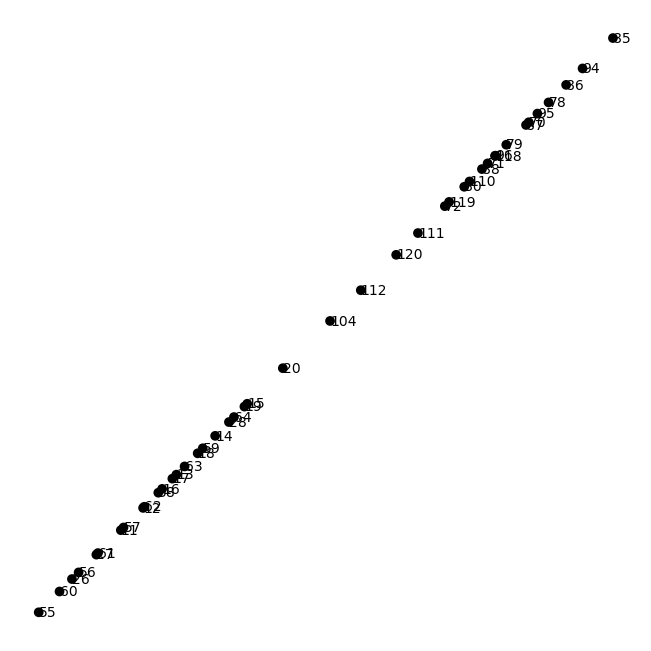

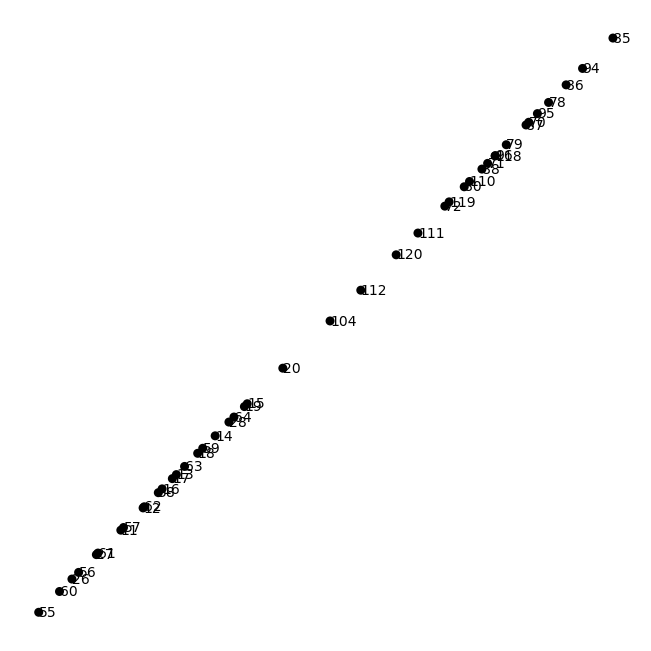

In [39]:
# Read the CSV file
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep187/ep187_rois.csv")

# Define the value to add
value_to_add = np.array([-98.18610191345215, -108.80819797515869, -118.60360145568848]) 

# Filter the dataframe
electrode_filtered_df = electrode_df[electrode_df["label"] == 101]

# Convert the position strings to tuples
electrode_filtered_df["position"] = electrode_filtered_df["position"].apply(ast.literal_eval)

# Extract 3D positions and adjust them
electrodes_3d = np.array(list(electrode_filtered_df["position"]))
adjusted_positions = electrodes_3d + value_to_add

# Apply a 90-degree rotation around the z-axis
rotated_positions = np.copy(adjusted_positions)
rotated_positions[:, 0], rotated_positions[:, 1] = -rotated_positions[:, 1], rotated_positions[:, 0]

# Create a dictionary of rotated electrode positions using 'electrode_number'
electrode_positions_3d = {str(int(num)): tuple(pos) for num, pos in zip(electrode_filtered_df["electrode_number"], rotated_positions)}

# Create a montage from these positions
montage = mne.channels.make_dig_montage(ch_pos=electrode_positions_3d)

# Create a dummy Info object with the same number of channels as electrodes
info = mne.create_info(ch_names=list(electrode_positions_3d.keys()), sfreq=1000, ch_types='eeg')

# Create a dummy Raw object and set the montage
raw = mne.io.RawArray(np.zeros((len(electrode_positions_3d), 1)), info)
raw.set_montage(montage)

# Visualize the 2D projection
mne.viz.plot_montage(montage)


In [ ]:
import nibabel as nib

nifti_file = '/Users/siyuanzhao/Downloads/file.nii.gz'
img = nib.load(nifti_file)

# Get the data from the image
data = img.get_fdata()

x, y = zip(*electrode_2d_positions)

# Create a scatter plot of the 2D electrode positions
plt.scatter(x, y)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Electrode Arrangement')
plt.show()

In [81]:
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_new.csv")

# Define the value to add
value_to_add = np.array([-98.18610191345215, -108.80819797515869, -118.60360145568848]) 

electrode_df["position"] = electrode_df["position"].apply(ast.literal_eval)

# Extract 3D positions and adjust them
electrodes_3d = np.array(list(electrode_df["position"]))
adjusted_positions = electrodes_3d + value_to_add

def perspective_projection(matrix, d):
    projected_matrix = np.zeros((matrix.shape[0], 2))
    for i in range(matrix.shape[0]):
        projected_matrix[i, 0] = matrix[i, 0] * d / matrix[i, 2] # x projection
        projected_matrix[i, 1] = matrix[i, 1] * d / matrix[i, 2] # y projection
    return projected_matrix


# Perspective projection (assuming d = 5)
perspective_proj = perspective_projection(adjusted_positions, 5)
print("Perspective Projection:\n", perspective_proj)


Perspective Projection:
 [[-3.96705879e+00  1.00788820e+01]
 [-4.37896224e+00  9.03489956e+00]
 [-4.59690755e+00  7.58578013e+00]
 [-4.91992683e+00  6.27994793e+00]
 [-4.84072183e+00  5.03708392e+00]
 [-4.86068680e+00  4.19917073e+00]
 [-4.65036629e+00  3.28553342e+00]
 [-4.62351586e+00  2.53286432e+00]
 [-5.78310373e+00  1.09550673e+01]
 [-5.79406210e+00  9.04931444e+00]
 [-6.29429700e+00  7.38826685e+00]
 [-6.10213152e+00  5.93539902e+00]
 [-6.06500873e+00  4.89905709e+00]
 [-5.71115031e+00  3.60664534e+00]
 [-5.70096601e+00  2.72169487e+00]
 [-7.77336688e+00  1.81893252e+01]
 [-8.21916551e+00  1.47136169e+01]
 [-8.15585695e+00  1.17787833e+01]
 [-8.24865186e+00  9.55193511e+00]
 [-8.19231503e+00  7.62579422e+00]
 [-7.71777854e+00  5.78481859e+00]
 [-7.14092609e+00  4.10935006e+00]
 [-6.96410714e+00  3.06641766e+00]
 [-1.15949124e+01  2.63936909e+01]
 [-1.32034493e+01  2.35877351e+01]
 [-1.29196093e+01  1.81407121e+01]
 [-1.21043670e+01  1.36335616e+01]
 [-1.15854870e+01  1.05801729e

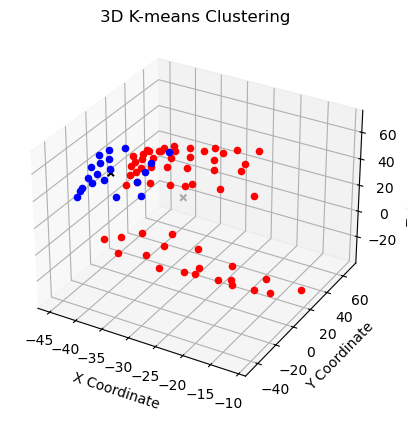

In [82]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_new.csv")

# Define the value to add
value_to_add = np.array([-98.18610191345215, -108.80819797515869, -118.60360145568848]) 

electrode_df["position"] = electrode_df["position"].apply(ast.literal_eval)

# Extract 3D positions and adjust them
electrodes_3d = np.array(list(electrode_df["position"]))
adjusted_positions = electrodes_3d + value_to_add

# Number of clusters (change this based on your data)
k = 2

# Apply K-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(adjusted_positions)

# Cluster centers
centers = kmeans.cluster_centers_

# Cluster labels for each point
labels = kmeans.labels_

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange']

for i in range(len(adjusted_positions)):
    ax.scatter(adjusted_positions[i][0], adjusted_positions[i][1], adjusted_positions[i][2], c=colors[labels[i]])

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', marker='x')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('3D K-means Clustering')
plt.show()


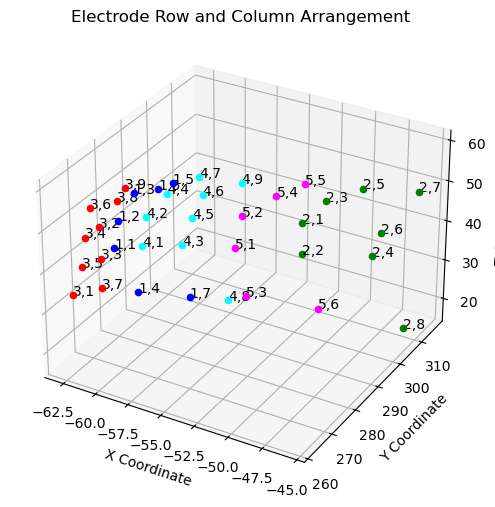

In [126]:
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 2]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[2]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)

converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]
converted_roi2_arr

positions = np.array(converted_roi2_arr)
num_rows = 5

kmeans = KMeans(n_clusters=num_rows)
row_labels = kmeans.fit_predict(positions[:, [1]])  # Using the y-coordinate for clustering

# Sort positions within each row based on another coordinate (e.g., x-coordinate)
sorted_positions = []
for i in range(num_rows):
    row_positions = positions[row_labels == i]
    sorted_indices = np.argsort(row_positions[:, 0])  # Sorting based on x-coordinate
    sorted_positions.append(row_positions[sorted_indices])

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

# Plot each point and label it with row and column index
for row_index, row in enumerate(sorted_positions):
    for col_index, position in enumerate(row):
        ax.scatter(*position, label=f'Row {row_index+1}, Col {col_index+1}', color=colors[row_index])
        ax.text(*position, f'{row_index+1},{col_index+1}')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Electrode Row and Column Arrangement')
# plt.legend()
plt.show()

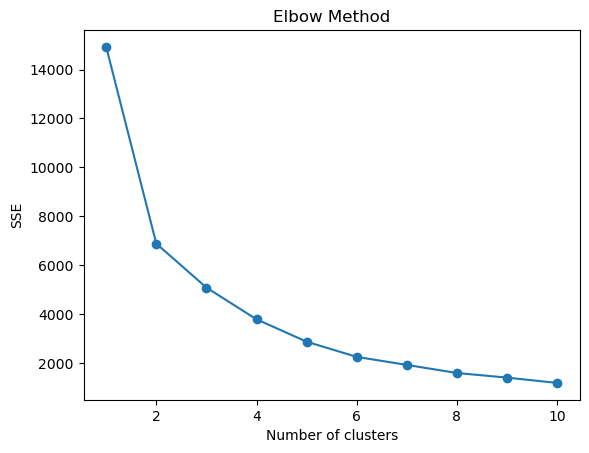

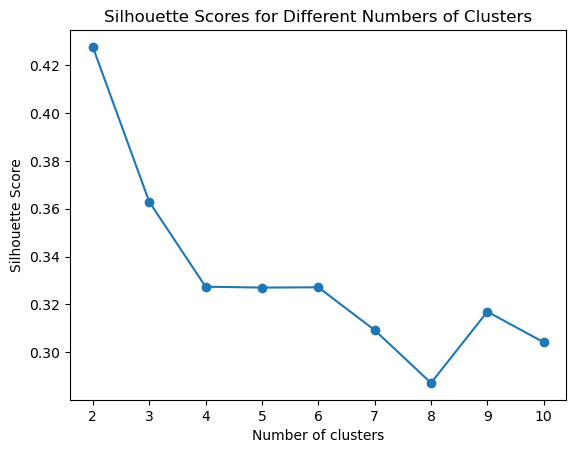

In [127]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 2]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[2]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)

converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]
converted_roi2_arr

positions = np.array(converted_roi2_arr)
sse = []
for k in range(1, 11):  # Example: trying from 1 to 10 clusters
    kmeans = KMeans(n_clusters=k).fit(positions)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in range(2, 11):  # Silhouette score can't be computed with 1 cluster
    kmeans = KMeans(n_clusters=k).fit(positions)
    score = silhouette_score(positions, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.show()

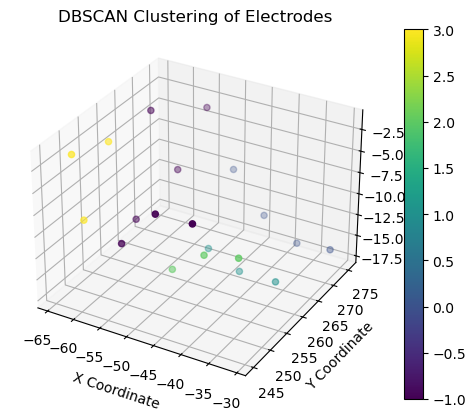

In [146]:
from sklearn.cluster import DBSCAN
import numpy as np

electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 1]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[1]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)

converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]
converted_roi2_arr

positions = np.array(converted_roi2_arr)

# Apply DBSCAN clustering
# eps and min_samples need to be tuned based on your data characteristics
dbscan = DBSCAN(eps=8, min_samples=3)  # Example parameters
clusters = dbscan.fit_predict(positions)

# Process clusters to identify rows and columns
# This will require analyzing the cluster labels and positions

# Visualization (optional)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(positions[:,0], positions[:,1], positions[:,2], c=clusters)

# Adding color bar to distinguish clusters
plt.colorbar(scatter)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('DBSCAN Clustering of Electrodes')
plt.show()


In [130]:
def read_obj(filename):
    vertices = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Vertex description (ignores vn and vt lines)
                parts = line.split()
                vertex = [float(coord) for coord in parts[1:4]]
                vertices.append(vertex)
    return vertices

def calculate_centroid(vertices):
    mean_x = sum(vertex[0] for vertex in vertices) / len(vertices)
    mean_y = sum(vertex[1] for vertex in vertices) / len(vertices)
    mean_z = sum(vertex[2] for vertex in vertices) / len(vertices)
    return mean_x, mean_y, mean_z

# Example usage
filename = '/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/models/ep187/ep187_brain.obj'  # Replace with your OBJ file path
vertices = read_obj(filename)
centroid = calculate_centroid(vertices)
print("Centroid:", centroid)


Centroid: (0.31623776825780947, 1.6678353811513458, -3.470437038283673)


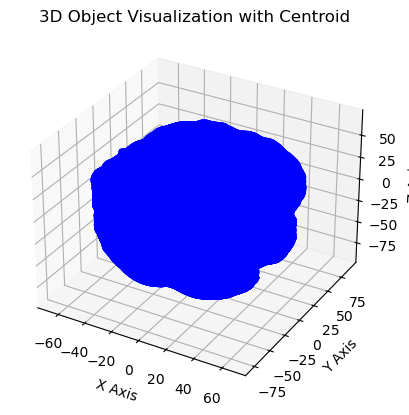

In [134]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def read_obj(filename):
    vertices = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('v '):  # Vertex description (ignores vn and vt lines)
                parts = line.split()
                vertex = [float(coord) for coord in parts[1:4]]
                vertices.append(vertex)
    return vertices

def calculate_centroid(vertices):
    mean_x = sum(vertex[0] for vertex in vertices) / len(vertices)
    mean_y = sum(vertex[1] for vertex in vertices) / len(vertices)
    mean_z = sum(vertex[2] for vertex in vertices) / len(vertices)
    return mean_x, mean_y, mean_z

# Example usage
filename = '/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/models/ep187/ep187_brain.obj'  # Replace with your OBJ file path      # Replace with your OBJ file path
vertices = read_obj(filename)
centroid = calculate_centroid(vertices)

# Convert list of vertices to a numpy array for easier plotting
vertices = np.array(vertices)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the vertices
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], color='b', marker='o', s=1)

# Plot the centroid
ax.scatter(*centroid, color='r', marker='x', s=100)

# Setting labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Object Visualization with Centroid')

plt.show()


[array([[-61.84310535, 286.55914148,  34.41125867],
       [-61.58871844, 287.06501611,  41.78996655],
       [-60.04178241, 293.51214441,  32.8874397 ],
       [-59.89812854, 287.17295679,  49.16273877],
       [-59.32251361, 293.95680078,  40.24165723],
       [-58.38990787, 293.48835596,  46.95895764],
       [-57.47140887, 287.37705835,  55.24007031],
       [-56.12125781, 291.48889001,  23.5542793 ],
       [-55.45594028, 293.71443018,  52.56364819]]), array([[-53.46968463, 308.5296615 ,  36.76735303],
       [-53.45025256, 308.37077173,  29.00400159],
       [-51.70014575, 308.69558557,  43.89207837],
       [-49.17988971, 315.1840957 ,  28.9357948 ],
       [-48.97822192, 308.48599084,  49.65683362],
       [-48.72851184, 316.00419458,  34.89601514],
       [-45.72175983, 314.19163354,  49.02406689],
       [-45.69976428, 308.71671899,  17.14986035]]), array([[-62.34460452, 262.51482996,  34.43300244],
       [-62.29856494, 272.58552393,  46.05153271],
       [-62.20232776, 272.

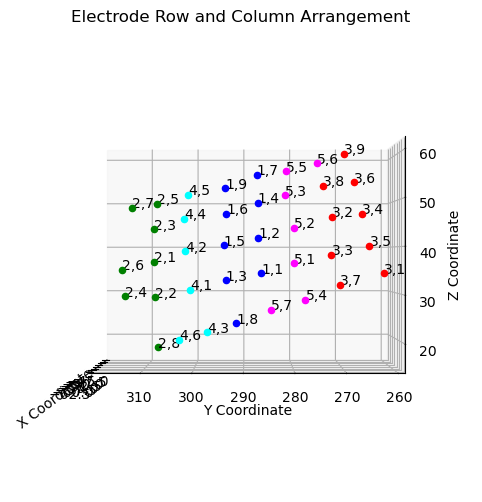

In [30]:
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 2]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[2]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)

converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]
converted_roi2_arr

positions = np.array(converted_roi2_arr)
num_rows = 5

kmeans = KMeans(n_clusters=num_rows)
row_labels = kmeans.fit_predict(positions[:, [1]])  # Using the y-coordinate for clustering

# Sort positions within each row based on another coordinate (e.g., x-coordinate)
sorted_positions = []
for i in range(num_rows):
    row_positions = positions[row_labels == i]
    sorted_indices = np.argsort(row_positions[:, 0])  # Sorting based on x-coordinate
    sorted_positions.append(row_positions[sorted_indices])

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

# Plot each point and label it with row and column index
for row_index, row in enumerate(sorted_positions):
    for col_index, position in enumerate(row):
        ax.scatter(*position, label=f'Row {row_index+1}, Col {col_index+1}', color=colors[row_index])
        ax.text(*position, f'{row_index+1},{col_index+1}')

ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Electrode Row and Column Arrangement')
# plt.legend()
plt.show()


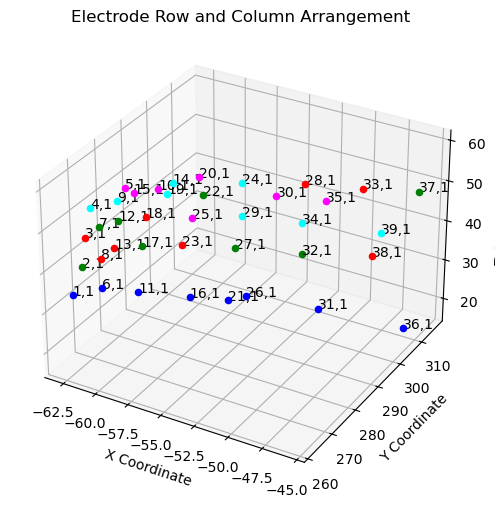

In [181]:
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 2]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[2]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)


converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]

positions = np.array(converted_roi2_arr)

# Sort positions by y-coordinate to separate rows
positions_sorted_by_y = positions[np.argsort(positions[:, 1])]

# Group electrodes into rows and sort each row by x-coordinate
sorted_positions = []
current_row = []
last_y = positions_sorted_by_y[0][1]

for position in positions_sorted_by_y:
    if position[1] != last_y:
        # Sort the current row by x-coordinate and add to sorted_positions
        sorted_positions.append(np.array(sorted(current_row, key=lambda x: x[0])))
        current_row = []
    current_row.append(position)
    last_y = position[1]

# Don't forget to add the last row
sorted_positions.append(np.array(sorted(current_row, key=lambda x: x[0])))

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta'])

# Plot each point and label it with row and column index
for row_index, row in enumerate(sorted_positions):
    current_color = next(color_cycle)
    for col_index, position in enumerate(row):
        ax.scatter(*position, color=current_color)
        ax.text(*position, f'{row_index+1},{col_index+1}')
# ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Electrode Row and Column Arrangement')
plt.show()


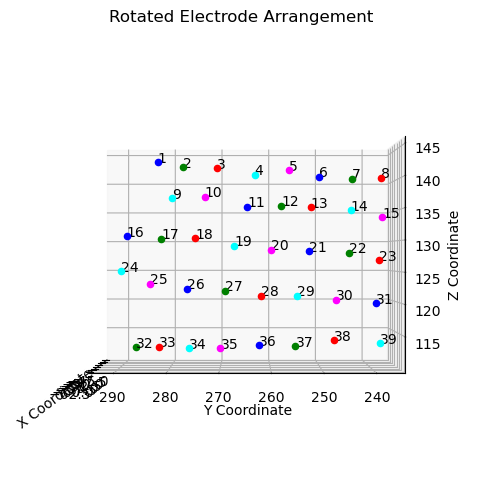

In [141]:
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 2]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[2]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)


converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]
def rotation_matrix_x(theta):
    cos_theta, sin_theta = np.cos(np.radians(theta)), np.sin(np.radians(theta))
    return np.array([[1, 0, 0],
                     [0, cos_theta, -sin_theta],
                     [0, sin_theta, cos_theta]])

# Angle of rotation in degrees
theta = 18
positions = np.array(converted_roi2_arr)

rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta'])

# Plot each point and label it with row and column index
for row_index, row in enumerate(rotated_positions):
    current_color = next(color_cycle)
    ax.scatter(*row, color=current_color)
    ax.text(*row, f'{row_index+1}')
ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement')
plt.show()


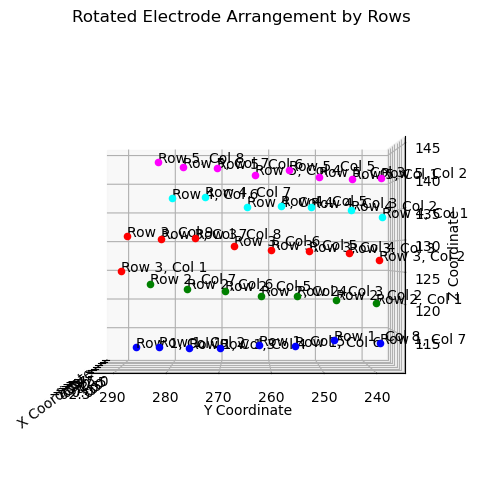

In [145]:
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 2]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[2]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)


converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]
def rotation_matrix_x(theta):
    cos_theta, sin_theta = np.cos(np.radians(theta)), np.sin(np.radians(theta))
    return np.array([[1, 0, 0],
                     [0, cos_theta, -sin_theta],
                     [0, sin_theta, cos_theta]])

# Angle of rotation in degrees
theta = 18
positions = np.array(converted_roi2_arr)

rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)
rotated_positions_sorted_by_z = rotated_positions[np.argsort(rotated_positions[:, 2])]

z_threshold = 2
rows = []
current_row = []
last_z = rotated_positions_sorted_by_z[0][2]

for position in rotated_positions_sorted_by_z:
    if abs(position[2] - last_z) > z_threshold:
        rows.append(current_row)
        current_row = []
    current_row.append(position)
    last_z = position[2]

# Don't forget to add the last row
rows.append(current_row)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows):
    current_color = next(color_cycle)
    for col_index, position in enumerate(row):
        ax.scatter(*position, color=current_color)
        ax.text(*position, f'Row {row_index+1}, Col {col_index+1}')
        

ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

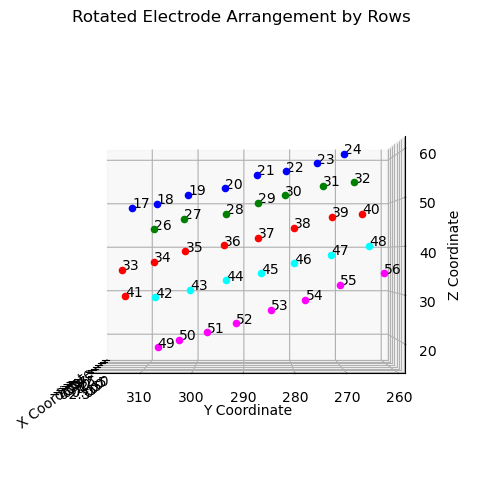

In [170]:
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on ROI and get their positions
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 2]
for item in electrode_roi_2_df["electrodes"].iloc[0]:  # Assuming electrode numbers are in the first row
    if item in electrode_position_map:
        # print(electrode_position_map[item], '?????')
        roi2_arr.append(electrode_position_map[item])


# Rotate the positions
theta = 18
positions = np.array(roi2_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 2
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]
    
rows_electrode_numbers.append(current_row_electrode_numbers)

# Save the rows of electrode numbers to a JSON file
with open('roi2_electrodes.json', 'w') as f:
    json.dump(rows_electrode_numbers, f)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        

ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()


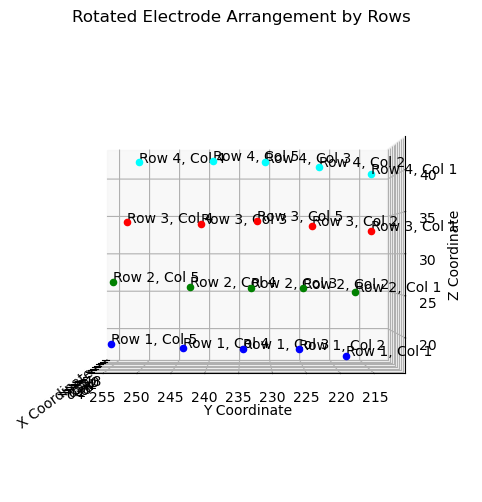

In [176]:
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 0]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[0]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)


converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]
def rotation_matrix_x(theta):
    cos_theta, sin_theta = np.cos(np.radians(theta)), np.sin(np.radians(theta))
    return np.array([[1, 0, 0],
                     [0, cos_theta, -sin_theta],
                     [0, sin_theta, cos_theta]])

# Angle of rotation in degrees
theta = -10
positions = np.array(converted_roi2_arr)

rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)
rotated_positions_sorted_by_z = rotated_positions[np.argsort(rotated_positions[:, 2])]

z_threshold = 2
rows = []
current_row = []
last_z = rotated_positions_sorted_by_z[0][2]

for position in rotated_positions_sorted_by_z:
    if abs(position[2] - last_z) > z_threshold:
        rows.append(current_row)
        current_row = []
    current_row.append(position)
    last_z = position[2]

# Don't forget to add the last row
rows.append(current_row)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows):
    current_color = next(color_cycle)
    for col_index, position in enumerate(row):
        ax.scatter(*position, color=current_color)
        ax.text(*position, f'Row {row_index+1}, Col {col_index+1}')
        

ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

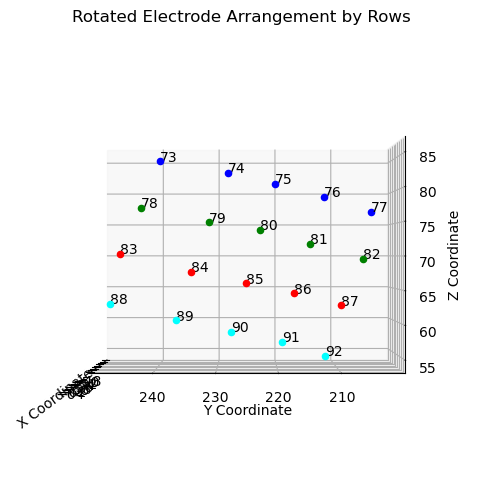

In [179]:
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on ROI and get their positions
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 0]
for item in electrode_roi_2_df["electrodes"].iloc[0]:  # Assuming electrode numbers are in the first row
    if item in electrode_position_map:
        # print(electrode_position_map[item], '?????')
        roi2_arr.append(electrode_position_map[item])


# Rotate the positions
theta = -10
positions = np.array(roi2_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 2
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]
    
rows_electrode_numbers.append(current_row_electrode_numbers)

# Save the rows of electrode numbers to a JSON file
with open('roi0_electrodes.json', 'w') as f:
    json.dump(rows_electrode_numbers, f)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        

ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()


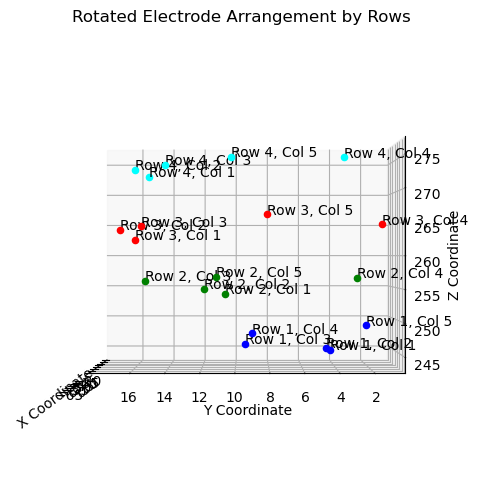

In [192]:
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 1]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[1]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)


converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]
def rotation_matrix_x(theta):
    cos_theta, sin_theta = np.cos(np.radians(theta)), np.sin(np.radians(theta))
    return np.array([[1, 0, 0],
                     [0, cos_theta, -sin_theta],
                     [0, sin_theta, cos_theta]])

# Angle of rotation in degrees
theta = 90
positions = np.array(converted_roi2_arr)

rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)
rotated_positions_sorted_by_z = rotated_positions[np.argsort(rotated_positions[:, 2])]

z_threshold = 2
rows = []
current_row = []
last_z = rotated_positions_sorted_by_z[0][2]

for position in rotated_positions_sorted_by_z:
    if abs(position[2] - last_z) > z_threshold:
        rows.append(current_row)
        current_row = []
    current_row.append(position)
    last_z = position[2]

# Don't forget to add the last row
rows.append(current_row)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows):
    current_color = next(color_cycle)
    for col_index, position in enumerate(row):
        ax.scatter(*position, color=current_color)
        ax.text(*position, f'Row {row_index+1}, Col {col_index+1}')
        

ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()

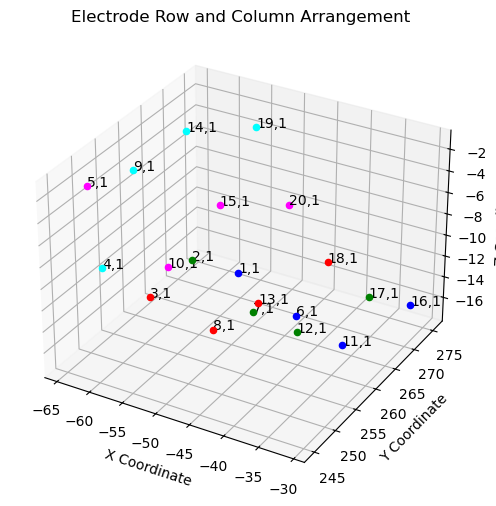

In [184]:
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 1]
electrode_filtered_2_df = electrode_roi_2_df["electrodes"]
electrode_df["electrode_number"]
for item in electrode_filtered_2_df[1]:
    for ele in electrode_df["electrode_number"]:
       if item == ele:
           selected_ele = electrode_df[electrode_df["electrode_number"] == ele]["position"].values[0]
           roi2_arr.append(selected_ele)


converted_roi2_arr = [ast.literal_eval(item) if isinstance(item, str) else item for item in roi2_arr]

positions = np.array(converted_roi2_arr)

# Sort positions by y-coordinate to separate rows
positions_sorted_by_y = positions[np.argsort(positions[:, 1])]

# Group electrodes into rows and sort each row by x-coordinate
sorted_positions = []
current_row = []
last_y = positions_sorted_by_y[0][1]

for position in positions_sorted_by_y:
    if position[1] != last_y:
        # Sort the current row by x-coordinate and add to sorted_positions
        sorted_positions.append(np.array(sorted(current_row, key=lambda x: x[0])))
        current_row = []
    current_row.append(position)
    last_y = position[1]

# Don't forget to add the last row
sorted_positions.append(np.array(sorted(current_row, key=lambda x: x[0])))

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta'])

# Plot each point and label it with row and column index
for row_index, row in enumerate(sorted_positions):
    current_color = next(color_cycle)
    for col_index, position in enumerate(row):
        ax.scatter(*position, color=current_color)
        ax.text(*position, f'{row_index+1},{col_index+1}')
# ax.view_init(elev=0, azim=180)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Electrode Row and Column Arrangement')
plt.show()


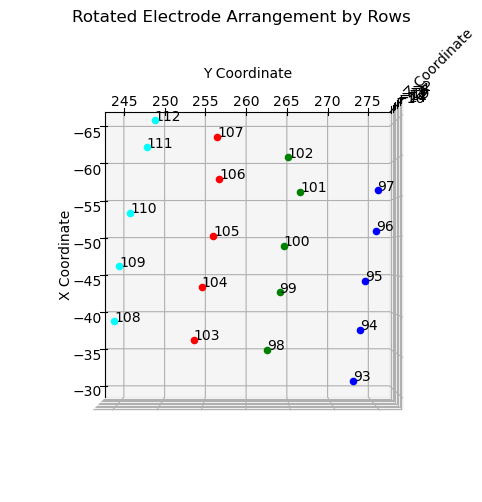

In [202]:
# Load your data
electrode_df = pd.read_csv("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/ep129_electrodes_relative.csv")
electrode_roi_df = pd.read_json("/Users/siyuanzhao/Documents/GitHub/CS529_VDS_Epilepsy/frontend/src/data/electrodes/ep129/sample1/ep129_sample1_full_network.json")

# Create a dictionary to map electrode numbers to positions
electrode_position_map = dict(zip(electrode_df["electrode_number"], electrode_df["position"].apply(ast.literal_eval)))

# Filter electrodes based on ROI and get their positions
roi2_arr = []
electrode_roi_2_df = electrode_roi_df[electrode_roi_df["roi"] == 1]
for item in electrode_roi_2_df["electrodes"].iloc[0]:  # Assuming electrode numbers are in the first row
    if item in electrode_position_map:
        # print(electrode_position_map[item], '?????')
        roi2_arr.append(electrode_position_map[item])


# Rotate the positions
theta = 90
positions = np.array(roi2_arr)
rotated_positions = np.dot(positions, rotation_matrix_x(theta).T)

# Sort rotated positions and find corresponding electrode numbers
z_threshold = 2
rows_electrode_numbers = []
current_row_electrode_numbers = []
last_z = rotated_positions[0, 2]

for position in rotated_positions:
    # Check the electrode number for each rotated position
    electrode_number = next((num for num, pos in electrode_position_map.items() if np.allclose(pos[0], position[0])), None)
    if abs(position[2] - last_z) > z_threshold:
        rows_electrode_numbers.append(current_row_electrode_numbers)
        current_row_electrode_numbers = []  
    if electrode_number is not None:
        current_row_electrode_numbers.append(electrode_number)
    last_z = position[2]
    
rows_electrode_numbers.append(current_row_electrode_numbers)

# Save the rows of electrode numbers to a JSON file
with open('roi1_electrodes.json', 'w') as f:
    json.dump(rows_electrode_numbers, f)

# Visualizing the result
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
color_cycle = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow'])

# Plot each point in rows
for row_index, row in enumerate(rows_electrode_numbers):
    current_color = next(color_cycle)
    for col_index, electrode_number in enumerate(row):
        # Find the position of this electrode number
        position = electrode_position_map[electrode_number]
        # Plot the electrode
        ax.scatter(*position, color=current_color)
        # Annotate the plot with the electrode number
        ax.text(*position, f'{electrode_number}')
        

ax.view_init(elev=90, azim=0)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.title('Rotated Electrode Arrangement by Rows')
plt.show()


In [9]:
# Reading the JSON file into a DataFrame
network_df = pd.read_json("/Users/siyuanzhao/Downloads/sample1_events.json")

propagation_counts = {}

# Iterating over the rows of the DataFrame
for _, item in network_df.iterrows():
    if item["network"]:  # Only proceed if network is not empty
        for electrode in item["electrodes"]:
            if electrode in propagation_counts:
                propagation_counts[electrode] += 1
            else:
                propagation_counts[electrode] = 1

# Convert the dictionary to the desired list format
result = [{"electrode_id": electrode_id, "propagation": count}
          for electrode_id, count in propagation_counts.items()]

print(result)
output_file = 'ep129_sample1_propagation.json'
with open(output_file, 'w') as file:
    json.dump(result, file, indent=4)

[{'electrode_id': 20, 'propagation': 237}, {'electrode_id': 32, 'propagation': 80}, {'electrode_id': 21, 'propagation': 181}, {'electrode_id': 22, 'propagation': 126}, {'electrode_id': 40, 'propagation': 67}, {'electrode_id': 41, 'propagation': 48}, {'electrode_id': 54, 'propagation': 35}, {'electrode_id': 19, 'propagation': 66}, {'electrode_id': 31, 'propagation': 139}, {'electrode_id': 39, 'propagation': 80}, {'electrode_id': 47, 'propagation': 40}, {'electrode_id': 48, 'propagation': 60}, {'electrode_id': 52, 'propagation': 133}, {'electrode_id': 56, 'propagation': 32}, {'electrode_id': 26, 'propagation': 108}, {'electrode_id': 27, 'propagation': 219}, {'electrode_id': 28, 'propagation': 214}, {'electrode_id': 29, 'propagation': 230}, {'electrode_id': 34, 'propagation': 57}, {'electrode_id': 35, 'propagation': 142}, {'electrode_id': 43, 'propagation': 45}, {'electrode_id': 49, 'propagation': 79}, {'electrode_id': 50, 'propagation': 76}, {'electrode_id': 53, 'propagation': 65}, {'ele

In [13]:
import pandas as pd

# Read the JSON file
propagation_df = pd.read_json("/Users/siyuanzhao/Downloads/ep129_sample1_full_network_new.json")
propagation_df = propagation_df[:-1]

electrode_counts = {}

# Iterate over each row in the DataFrame
for network_list in propagation_df['network']:
    # Now iterate over each item (dictionary) in the list
    for item in network_list:
        source = item['source']
        target = item['target']

        # Increment source count
        if source in electrode_counts:
            electrode_counts[source]['source_counts'] += 1
        else:
            electrode_counts[source] = {'electrode_id': source, 'source_counts': 1, 'target_counts': 0}

        # Increment target count
        if target in electrode_counts:
            electrode_counts[target]['target_counts'] += 1
        else:
            electrode_counts[target] = {'electrode_id': target, 'source_counts': 0, 'target_counts': 1}

# Convert the dictionary to a list of dictionaries
result = list(electrode_counts.values())

# Print or return the result
print(result)

output_file = 'ep129_sample1_propagation_new.json'
with open(output_file, 'w') as file:
    json.dump(result, file, indent=4)


[{'electrode_id': 74, 'source_counts': 126, 'target_counts': 109}, {'electrode_id': 73, 'source_counts': 107, 'target_counts': 97}, {'electrode_id': 76, 'source_counts': 115, 'target_counts': 101}, {'electrode_id': 89, 'source_counts': 81, 'target_counts': 54}, {'electrode_id': 84, 'source_counts': 77, 'target_counts': 103}, {'electrode_id': 90, 'source_counts': 17, 'target_counts': 16}, {'electrode_id': 75, 'source_counts': 120, 'target_counts': 95}, {'electrode_id': 80, 'source_counts': 9, 'target_counts': 9}, {'electrode_id': 85, 'source_counts': 14, 'target_counts': 50}, {'electrode_id': 91, 'source_counts': 5, 'target_counts': 7}, {'electrode_id': 86, 'source_counts': 1, 'target_counts': 19}, {'electrode_id': 81, 'source_counts': 3, 'target_counts': 2}, {'electrode_id': 83, 'source_counts': 2, 'target_counts': 6}, {'electrode_id': 79, 'source_counts': 1, 'target_counts': 10}, {'electrode_id': 107, 'source_counts': 72, 'target_counts': 53}, {'electrode_id': 102, 'source_counts': 17